In [1]:
import subprocess

import foyer
import mbuild as mb
import parmed
from mbuild.examples import Ethane, Propane

# mBuild + Foyer
Building our mBuild compound and applying our Foyer force field

In [2]:
cmpd = Ethane()
cmpd.name = "Eth"


box = mb.fill_box(cmpd, n_compounds=3, box=[10, 10, 10])

ff = foyer.forcefields.load_GAFF()
non_param = box.to_parmed(residues="Eth")
param = ff.apply(non_param, assert_dihedral_params=False)

/Users/ayang41/Programs/foyer/foyer/validator.py:132: ValidationWarning: You have empty smart definition(s)
  warn("You have empty smart definition(s)", ValidationWarning)
/Users/ayang41/Programs/foyer/foyer/forcefield.py:248: UserWarning: Parameters have not been assigned to all impropers. Total system impropers: 24, Parameterized impropers: 0. Note that if your system contains torsions of Ryckaert-Bellemans functional form, all of these torsions are processed as propers
  warnings.warn(msg)


# GOMC utility functions
Writing our GOMC control file, specifying our simulation parameters

In [3]:
def write_gomc_input(
    filename,
    parm_structure,
    coords="coords.pdb",
    structure="structure.psf",
    parameters="parameters.par",
    output="output",
):
    with open(filename, "w") as f:
        f.write(
            """ 
###########################################################################
#  ========-------------------- INPUT --------------------------===========
############################################################################

#########################
# enable, step
#########################
Restart     false


####################################
# kind (RESTART, RANDOM, INTSEED)
####################################
PRNG        RANDOM

####################################
# FORCE FIELD
####################################
ParaTypeCHARMM   true
ParaTypeEXOTIC   false
Parameters      {parameters}

####################################
# INPUT PDB FILES
####################################
Coordinates 0    {coords}

####################################
# INPUT PSF FILES
####################################
Structure 0      {structure}



############################################################################
#  =======--------------------- SYSTEM --------------------------===========
############################################################################

##################################
# GEMC TYPE (DEFULT IS NVT_GEMC)
##################################


#############################
# SIMULATION CONDITION
#############################
Temperature     300.00
Potential       VDW
LRC     true
Rcut        10
Exclude     1-4

#############################
# ELECTROSTATIC
#############################
ElectroStatic   false
Ewald           false
PressureCalc  true  1000

################################
# STEPS
################################
RunSteps           1000000
EqSteps        500000
AdjSteps       1000

################################
# MOVE FREQUENCY
################################
DisFreq               0.60
RotFreq           0.10
RegrowthFreq          0.30


################################
# BOX DIMENSION #, X, Y, Z
################################
CellBasisVector1 0  {box_x}  0.00    0.00
CellBasisVector2 0  0.00    {box_y}  0.00
CellBasisVector3 0  0.00    0.00    {box_z}


##############################
# CBMC TRIALS
##############################
CBMC_First   10
CBMC_Nth     8
CBMC_Ang     100
CBMC_Dih     20

####################################
#          Mol. Name     Chem. Pot.
####################################
############################################################################
#  =======-------------------- OUTPUT --------------------------===========
############################################################################

##########################
# statistics filename add
##########################
OutputName  {output}

#####################################
# enable, frequency
#####################################
CoordinatesFreq    true   1000000
RestartFreq        true   1000000
ConsoleFreq        true   100000
BlockAverageFreq   true   100000
HistogramFreq      false  100000


################################
# OutHistSettings
################################


##################################
# enable: blk avg., fluct.
##################################
OutEnergy         true    true
OutPressure       true    true
OutMolNum         true    true
OutDensity        true    true
""".format(
                structure=structure,
                coords=coords,
                parameters=parameters,
                output=output,
                box_x=parm_structure.box[0],
                box_y=parm_structure.box[1],
                box_z=parm_structure.box[2],
            )
        )

GOMC uses slightly modified CHARMM PAR files for force field parameters
in which the "ATOMS" section should be removed from the PAR file and the
"IMPROPERS" section should be renamed to "IMPROPER" (which is for GOMC and NAMD)

In [4]:
def modify_par_file(par_file):
    """GOMC parameter files do not use the atoms or impropers directive"""
    parlines = open(par_file).readlines()
    modified_parlines = open(par_file).readlines()
    found_atom_section = False
    to_delete = []
    for i, line in enumerate(parlines):
        if "ATOMS" in line:
            found_atom_section = True
            to_delete.append(i)
        elif found_atom_section:
            if "MASS" in line:
                to_delete.append(i)
            else:
                found_atom_section = False

        if "IMPROPERS" in line:
            modified_parlines[i] = "IMPROPER\n"
    to_delete.reverse()
    for delete_index in to_delete:
        modified_parlines.pop(delete_index)
    with open(par_file, "w") as f:
        for line in modified_parlines:
            f.write(line)

# Write out relevant files
PDB file specifies coordinates and atom names (be sure to use ATOM keywords in the PDB, not HETATM).
PSF file relates atoms, atom names, atom types, and bonding
PAR file contains force field information.
Prior to writing our PAR file, we need to "prepare" our `parmed.Structure` by converting it to a `parmed.CharmmParameterSet`. As a caveat, `parmed` modifies any atom types that are not completely upper-case, so we will capitalize all atom types.

In [5]:
# Save PDB and PSF files
param.save("coords.pdb", overwrite=True, use_hetatoms=False)
param.save("structure.psf", overwrite=True)

# Convert atomtypes to uppercase
for atom in param.atoms:
    atom.type = atom.type.upper()
    atom.atom_type.name = atom.atom_type.name.upper()

# Prepare parmed Structure by converting to CharmmParameterSet
paramset = parmed.charmm.CharmmParameterSet.from_structure(param)
paramset.write(par="parameters.par")

# Write GOMC run file, which requires box information and knowledge of other input files
write_gomc_input(
    "in.conf",
    param,
    coords="coords.pdb",
    structure="structure.psf",
    parameters="parameters.par",
)

# Post-process PAR file
modify_par_file("parameters.par")

# Run GOMC simulation

In [6]:
p = subprocess.Popen(
    "GOMC_CPU_NVT in.conf",
    shell=True,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    universal_newlines=True,
)
out, err = p.communicate()
with open("gomc.out", "w") as f:
    f.write(out)
with open("gomc.err", "w") as f:
    f.write(err)

# Analyze GOMC simulation
GOMC files are printed to stdout and block-averaged quantities are printed to a DAT file. 
We can use numpy and pandas to parse and organize these block-averagged quantities.

In [26]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [27]:
data = np.loadtxt("Blk_output_BOX_0.dat")
columns = open("Blk_output_BOX_0.dat").readlines()[0]
df = pd.DataFrame(data, columns=columns.split())

refdata = np.loadtxt("ref/Blk_output_BOX_0.dat")
refcolumns = open("ref/Blk_output_BOX_0.dat").readlines()[0]
refdf = pd.DataFrame(refdata, columns=columns.split())

Text(0, 0.5, 'Total Energy (K)')

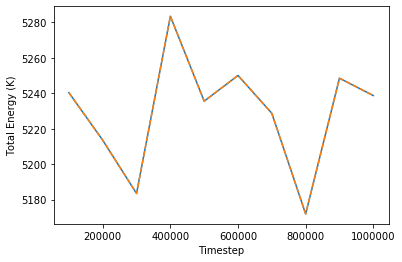

In [28]:
fig, ax = plt.subplots(1, 1)
ax.plot(df["#STEPS"], df["TOT_EN"], label="Simulated")
ax.plot(refdf["#STEPS"], refdf["TOT_EN"], linestyle="--", label="Simulated reference")
ax.set_xlabel("Timestep")
ax.set_ylabel("Total Energy (K)")

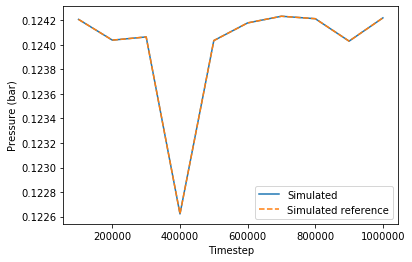

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(df["#STEPS"], df["PRESSURE"], label="Simulated")
ax.plot(refdf["#STEPS"], refdf["PRESSURE"], linestyle="--", label="Simulated reference")
ax.set_xlabel("Timestep")
ax.set_ylabel("Pressure (bar)")
ax.legend()

# Concluding Remarks

We have performed an NVT simulation in GOMC using a variety of Python libraries to help organize and simplify our work. The routines should serve as a good example for reproducibly and extensibly building your own GOMC workflows. Utilizing workflow managers for large-scale virtual screening is left as an exercise to the reader.